# **Exploration of nights sleep stored in .edf file**

In [1]:
!unzip drive/MyDrive/stanford_intership/mros.zip

Archive:  drive/MyDrive/stanford_intership/mros.zip
replace __MACOSX/._mros? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace mros/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/mros/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/mros/._polysomnography? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/mros/polysomnography/._edfs? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace __MACOSX/mros/polysomnography/._edfs? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace mros/polysomnography/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/mros/polysomnography/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/mros/polysomnography/._annotations-events-profusion? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace mros/polysomnography/edfs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/mros/polysomnography/edfs/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]enam

In [2]:
!pip install pyEDFlib

In [3]:
from pyedflib import highlevel,EdfReader
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import ticker
import xml.etree.ElementTree as et
import torch


##Where is your edf file?

In [4]:
path = './mros/polysomnography/edfs/visit1/mros-visit1-aa0001.edf'
path_annotaion = '/content/mros/polysomnography/annotations-events-profusion/visit1/mros-visit1-aa0001-profusion.xml'

##What data do you want?


In [5]:
interesting_labels = ['C3','C4','A1','A2','ROC','LOC']

##We extract information from file.edf 

In [6]:
# Selection of interesting labels
f = EdfReader(path)
all_labels = f.getSignalLabels()
interesting_channels = [idx for idx in np.arange(0,len(all_labels)) if all_labels[idx] in interesting_labels]

# Extraction of data
c = len(interesting_labels)
n = f.samples_in_file(interesting_channels[0])
data = np.zeros((c,n))
for ch in np.arange(c):
    data[ch,:] = f.readSignal(interesting_channels[ch])

freq = f.getSampleFrequencies()[interesting_channels[0]]
time = 1/freq*np.arange(0,n,dtype=float) # in secondes
total_time = int(time[-1]/60)            # in minutes
f.close()

# Extraction of sleep stages from file.xml
my_tree = et.parse(path_annotaion)
my_root = my_tree.getroot()
sleep_stages = []
for a in my_root[4]:
    stage = int(a.text)
    for i in range(256*30):
        sleep_stages.append(stage) 

In [7]:
time

array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       3.14999883e+04, 3.14999922e+04, 3.14999961e+04])

# Let's see what we have !

In [29]:
def exploration(start_time,duration):
    """ 
    Plot data of interest during the period
    INT : start_time, str in format 'hh:mm:ss'
              duration, int in minutes 
    OUT : start, int index of the start
              end, int index of the end """

    # Temporal space
    start = freq*(int(start_time[0:2])*3600+int(start_time[3:5])*60+int(start_time[6:8]))
    end = start+duration*freq*60

    fig = plt.figure(figsize=(15, 8), dpi=100)

    ax0 = plt.subplot(511)
    ax0.set_xlim(time[start], time[end-1])
    ax0.set_title('Sleep stages')
    plt.plot(time[start:end], sleep_stages[start:end])

    ax1 = plt.subplot(512,sharex=ax0)
    ax1.set_title('EEG n°1 : C3-A2')
    plt.plot(time[start:end], data[0][start:end]-data[3][start:end])

    ax2 = plt.subplot(513,sharex=ax0)
    ax2.set_title('EEG n°2 : C4-A1')
    plt.plot(time[start:end], data[1][start:end]-data[2][start:end])

    ax3 = plt.subplot(514,sharex=ax0)
    ax3.set_title('ROC-A1')
    plt.plot(time[start:end], data[4][start:end]-data[2][start:end])

    ax4 = plt.subplot(515,sharex=ax0)
    ax4.set_title('LOC-A2')
    plt.plot(time[start:end], data[5][start:end]-data[3][start:end])
    
    fig.canvas.draw()
    labels = [item.get_text() for item in ax0.get_xticklabels()]
    labels_format = []
    for idx in np.arange(len(labels)):
        labels_format.append("{:0>8}".format(str(timedelta(seconds=float(labels[idx])))))
    ax4.set_xticklabels(labels_format)
    plt.xlabel('Time')
    plt.setp(ax0.get_xticklabels(),visible=False)
    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    

    plt.tight_layout()
    plt.show()

    # Fourier space
    fig = plt.figure(figsize=(15, 8), dpi=100)
    duration = end - start  #seconde

    ax0 = plt.subplot(511)
    ax0.set_title('Fourier -> Sleep stages')
    ssf = torch.abs(torch.fft.rfft(torch.tensor(sleep_stages[start:end])))
    ssf[0]= 0
    plt.plot(np.arange(len(ssf))*freq/2/len(ssf), ssf,color='m')
    plt.xlim([0,0.001])

    ax1 = plt.subplot(512)
    ax1.set_title('Fourier -> EEG n°1 : C3-A2')
    data03f = torch.abs(torch.fft.rfft(torch.tensor(data[0][start:end]-data[3][start:end])))
    data03f[0] = 0
    plt.plot(np.arange(len(data03f))*freq/2/len(data03f), data03f,color='m')

    ax2 = plt.subplot(513,sharex=ax1)
    ax2.set_title('Fourier -> EEG n°2 : C4-A1')
    data12f = torch.abs(torch.fft.rfft(torch.tensor(data[1][start:end]-data[2][start:end])))
    data12f[0] = 0
    plt.plot(np.arange(len(data12f))*freq/2/len(data12f), data12f,color='m')

    ax3 = plt.subplot(514,sharex=ax1)
    ax3.set_title('Fourier -> ROC-A1')
    data42f = torch.abs(torch.fft.rfft(torch.tensor(data[4][start:end]-data[2][start:end])))
    data42f[0] = 0
    plt.plot(np.arange(len(data42f))*freq/2/len(data42f), data42f,color='m')

    ax4 = plt.subplot(515,sharex=ax1)
    ax4.set_title('Fourier -> LOC-A2')
    data53f = torch.abs(torch.fft.rfft(torch.tensor(data[5][start:end]-data[3][start:end])))
    data53f[0] = 0
    plt.plot(np.arange(len(data53f))*freq/2/len(data53f), data53f,color='m')
    plt.xlabel('Frequency (Hz)')
    plt.xlim([0,2])

    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)

    plt.tight_layout()
    plt.show()
    return start, end

##This is the whole night

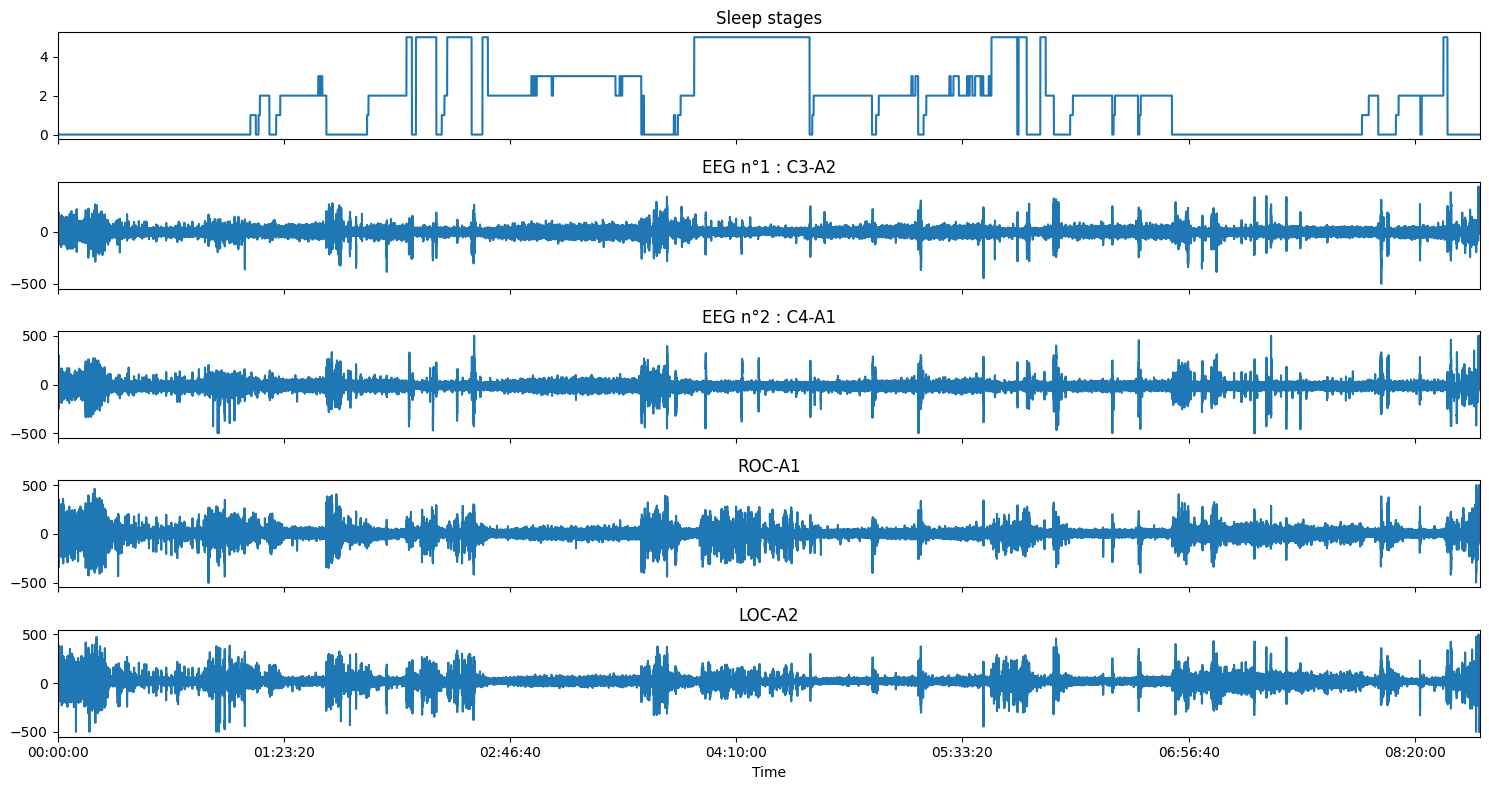

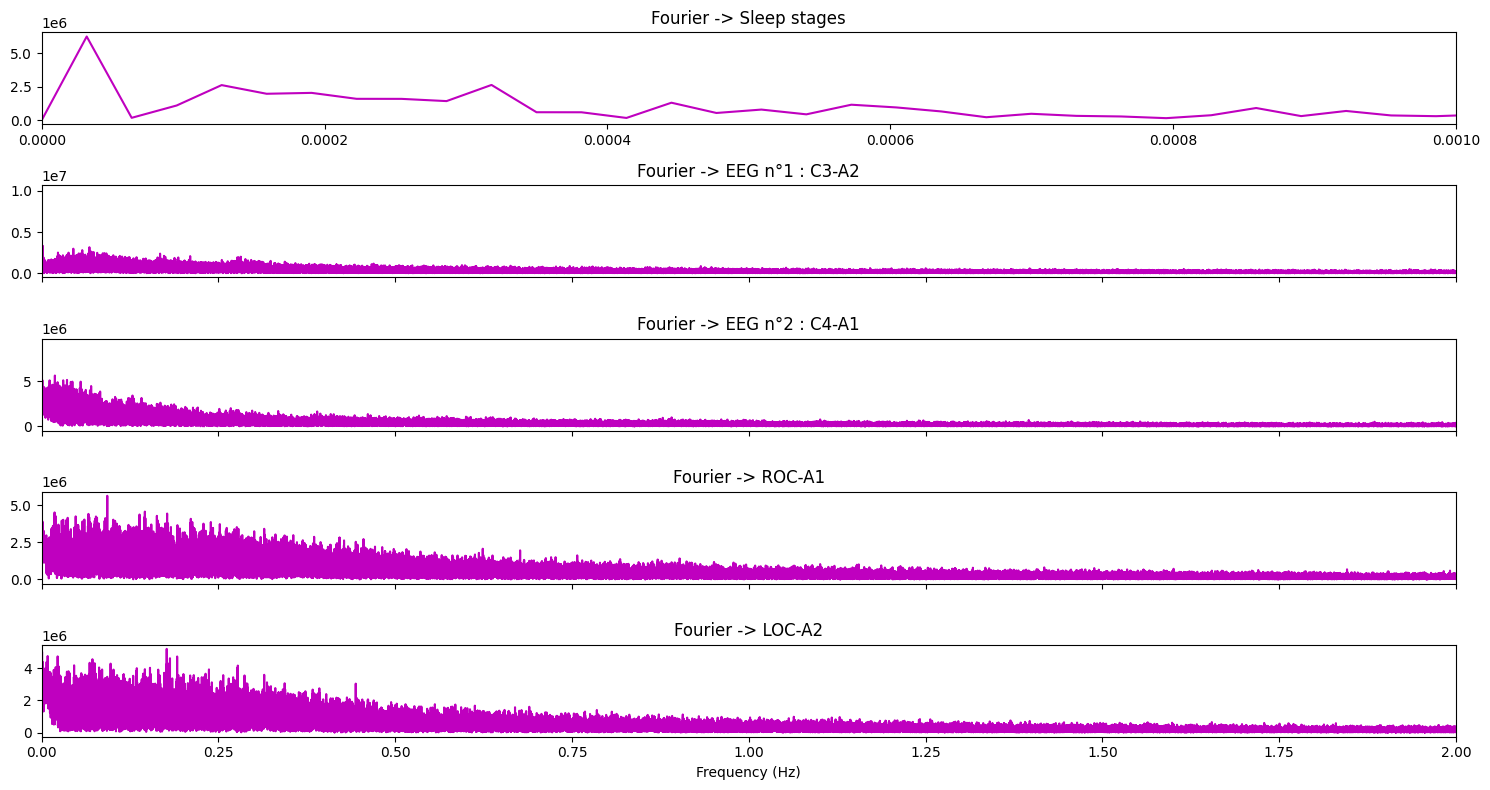

(0, 8048640)

In [30]:
exploration(start_time = '00:00:00', duration = total_time) 

#This is a full cycle of 90 minutes

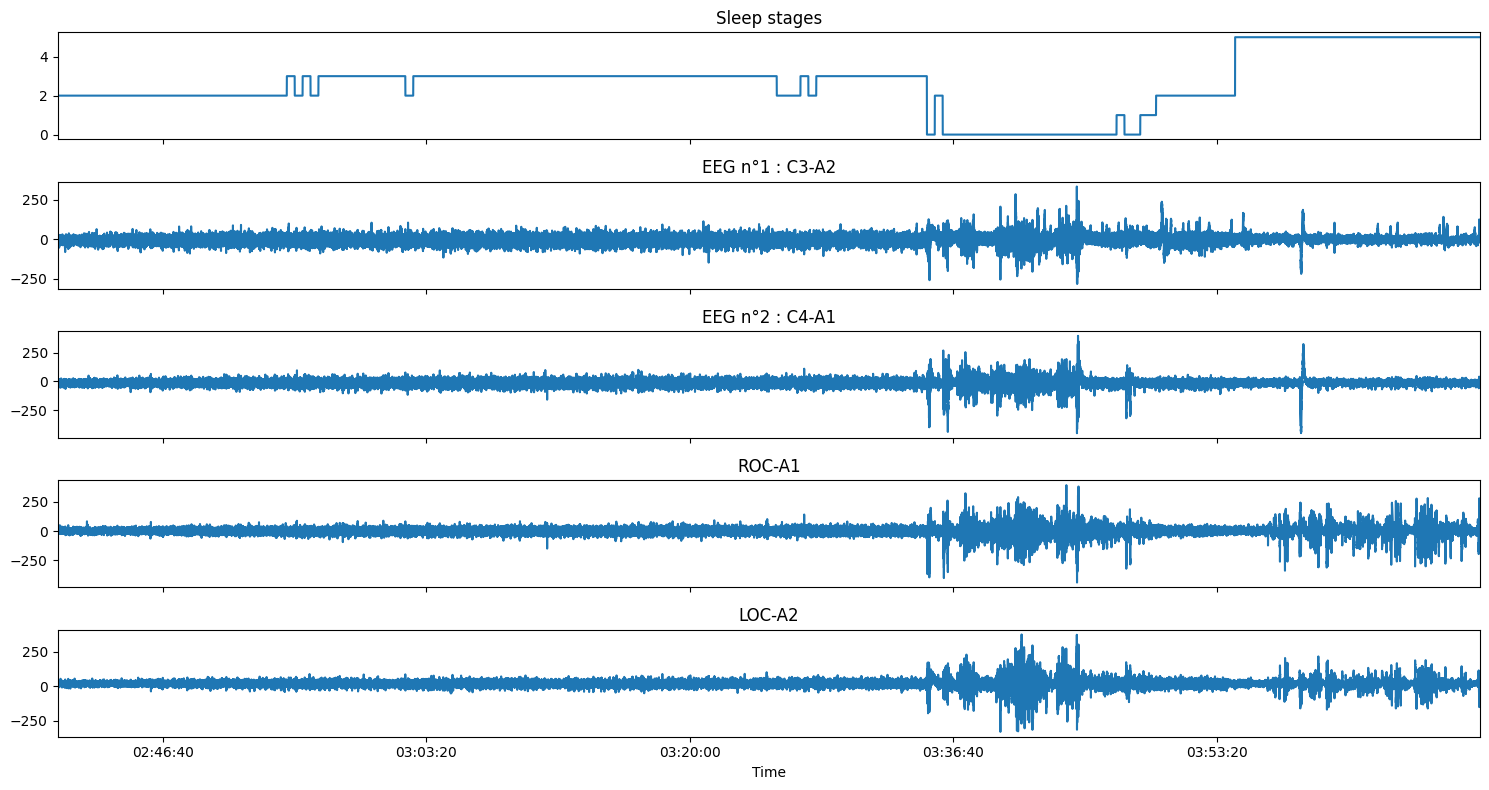

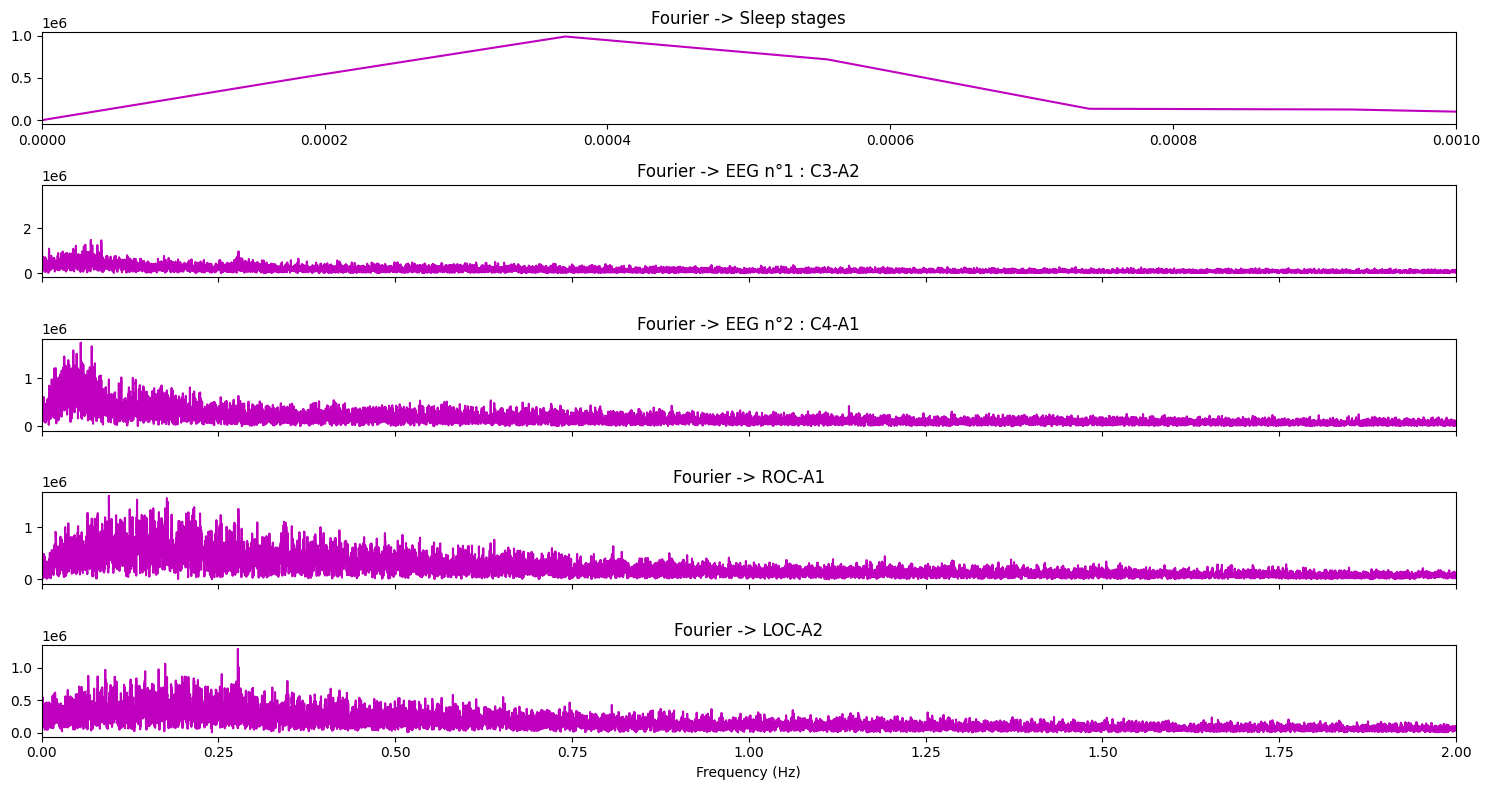

(2457600, 3840000)

In [31]:
exploration(start_time = '02:40:00', duration = 90)

##Stage 1 : low amplitude & high frequency

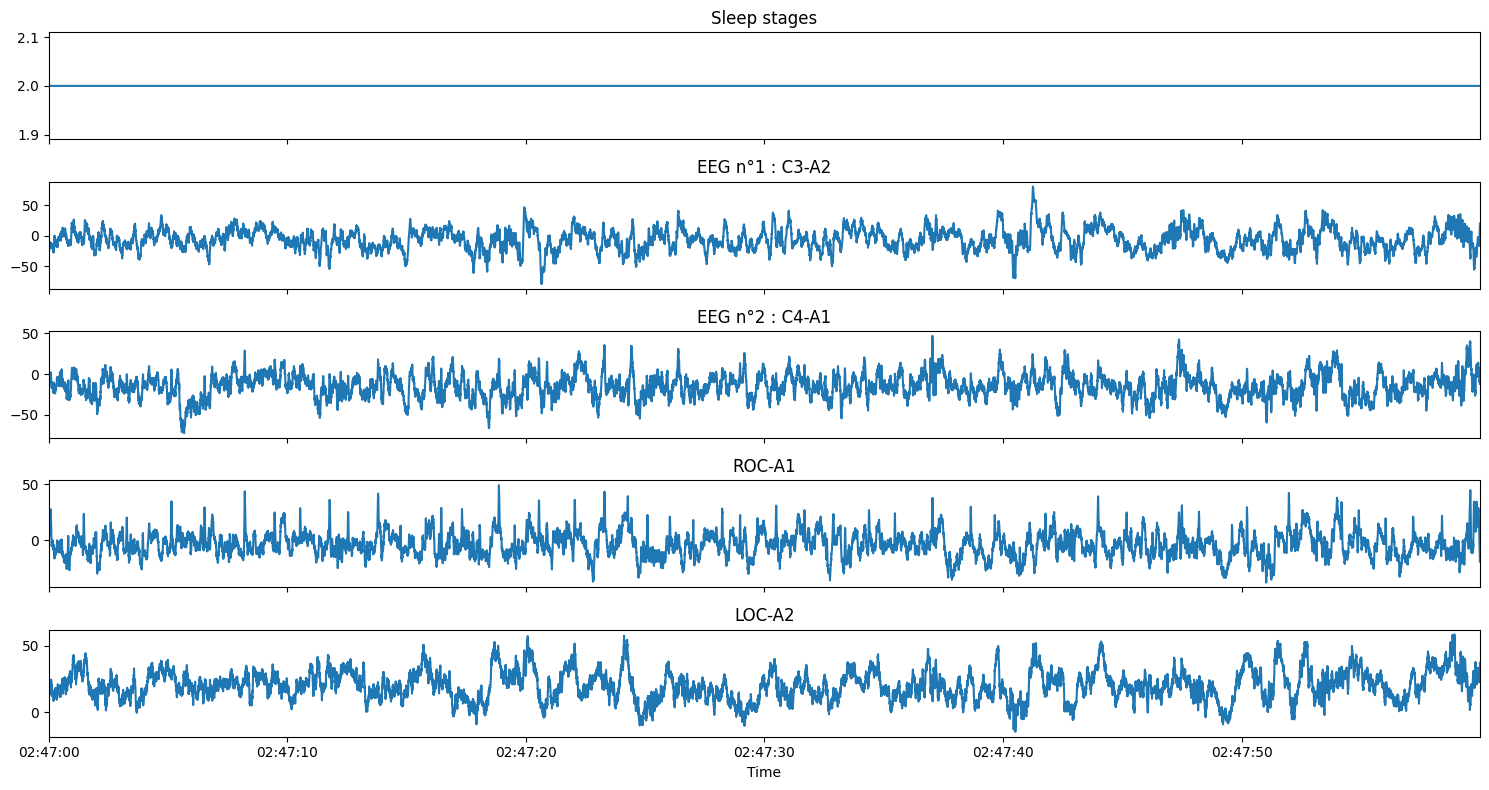

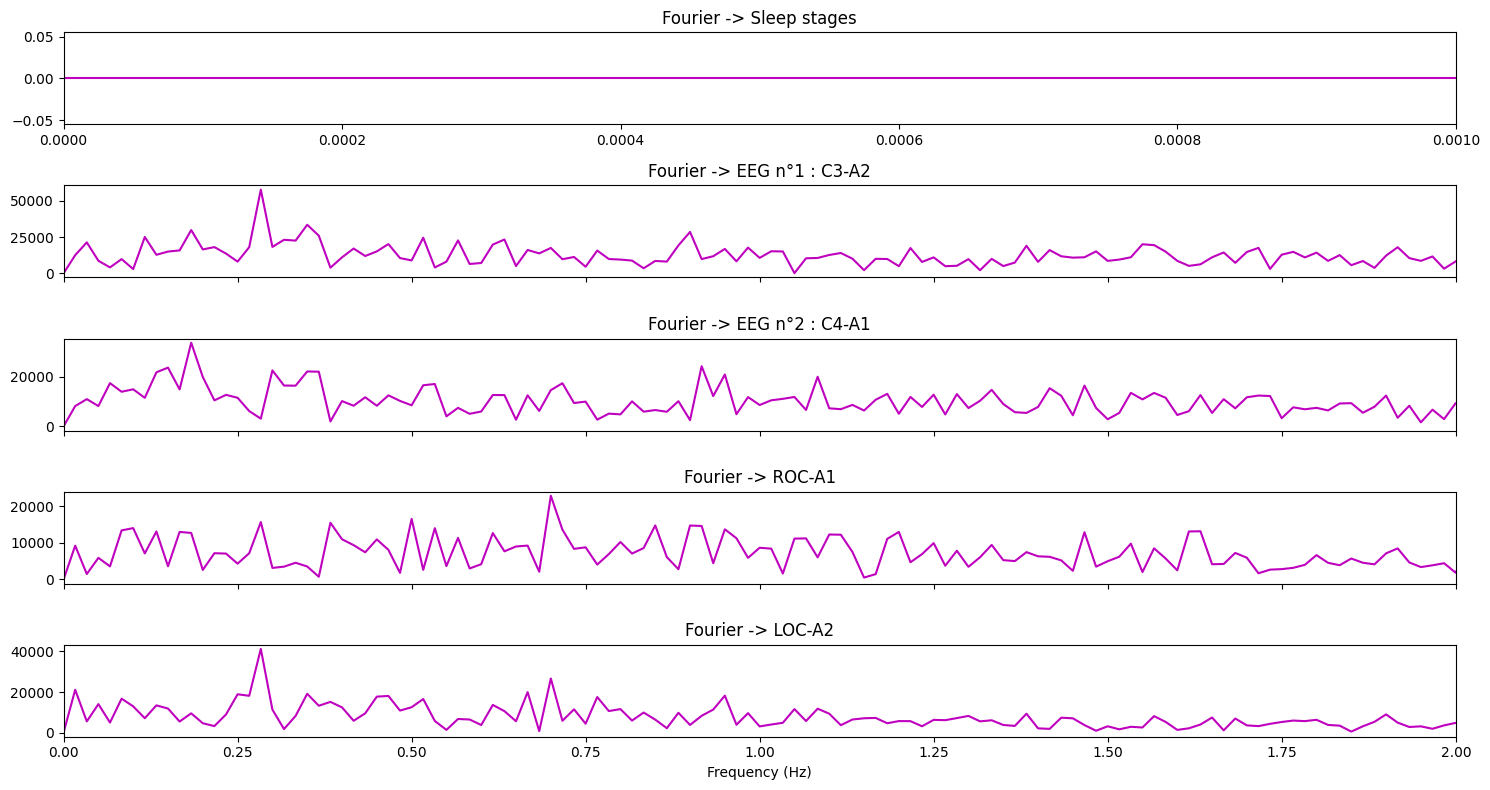

(2565120, 2580480)

In [32]:
exploration(start_time = '02:47:00', duration = 1)

##Stage 2 : sleep spindle and K-complex

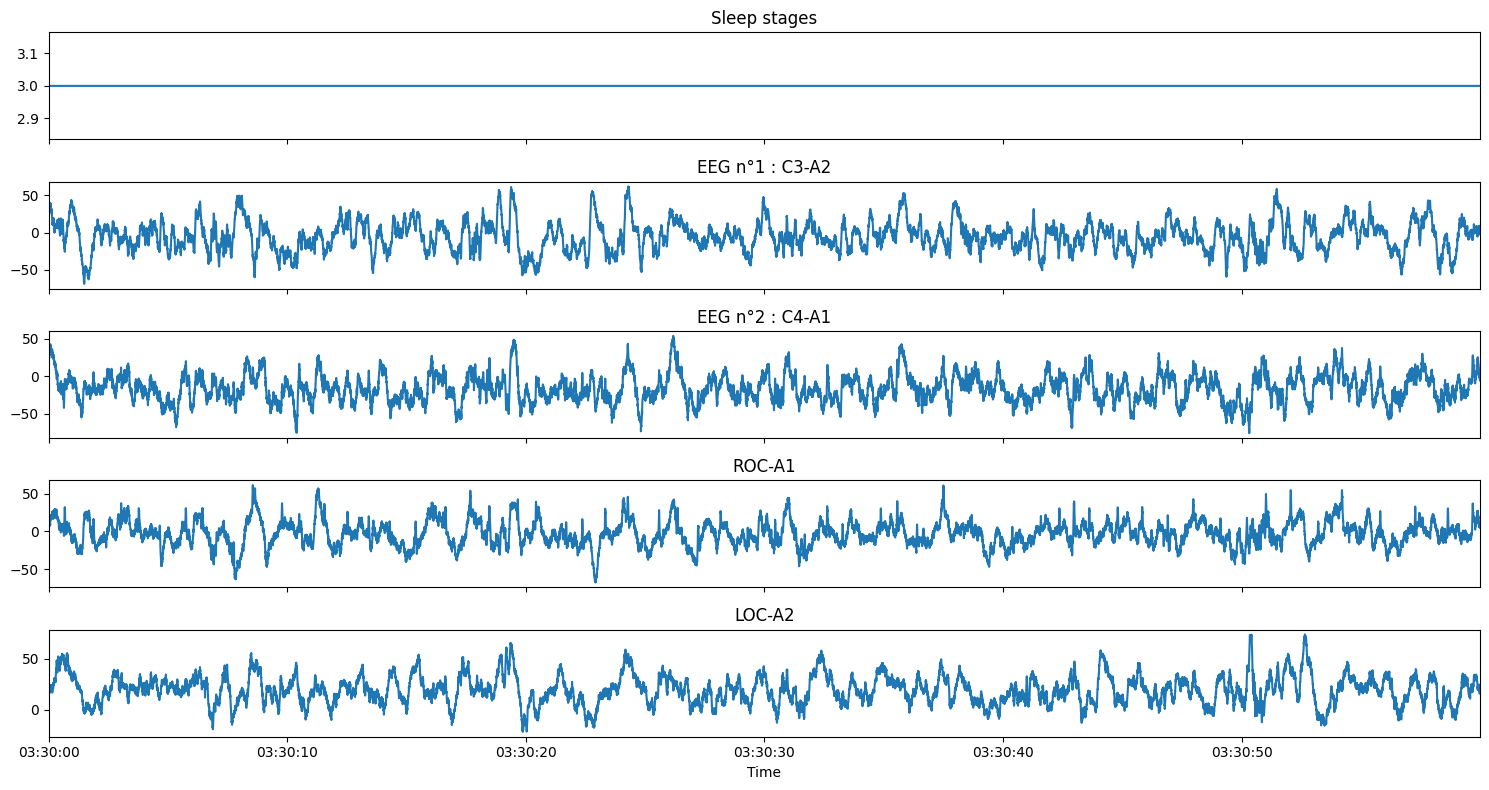

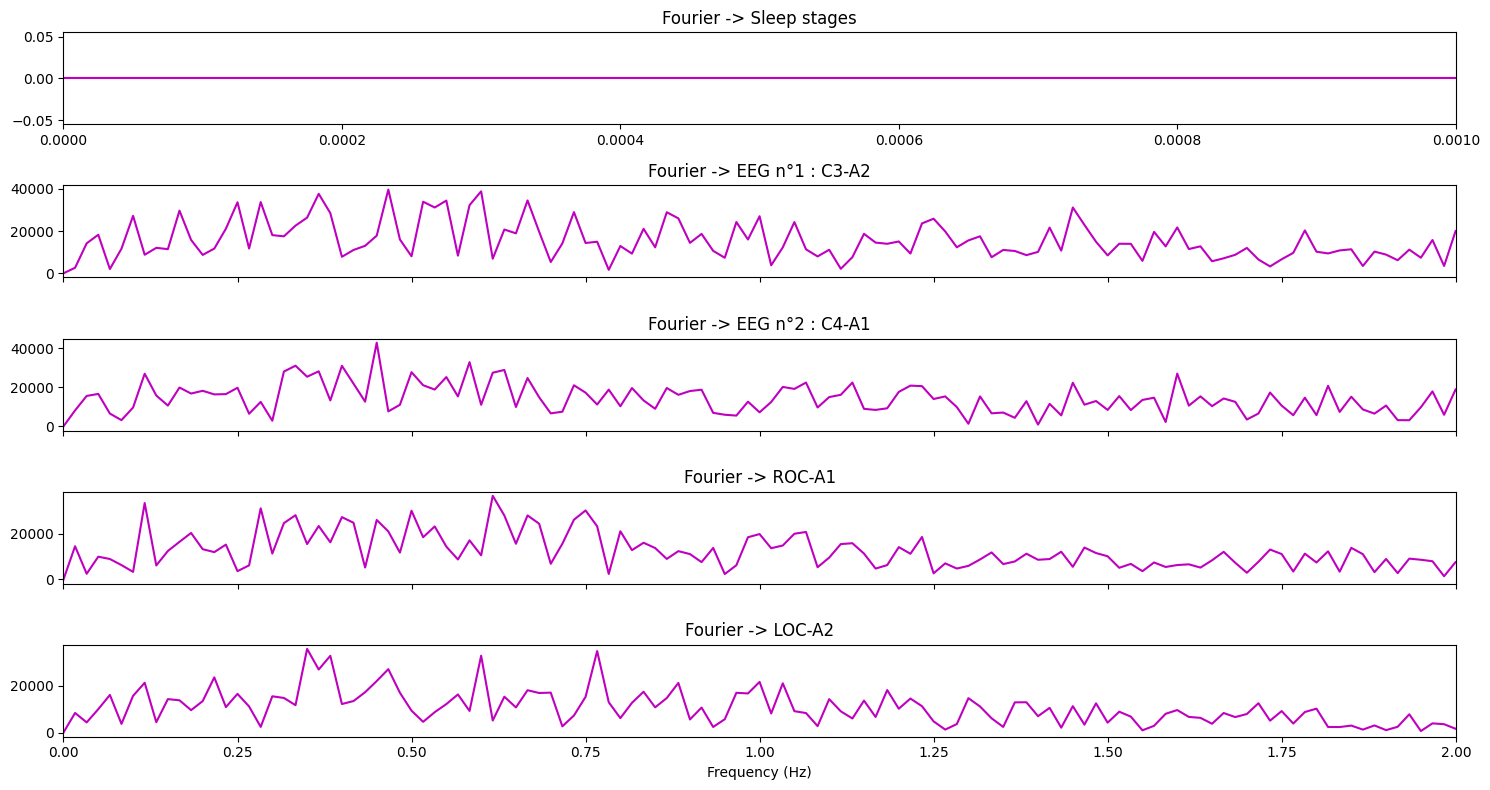

(3225600, 3240960)

In [33]:
exploration(start_time = '03:30:00', duration = 1)

##Stage 3 : High amplitude and delta **wave**

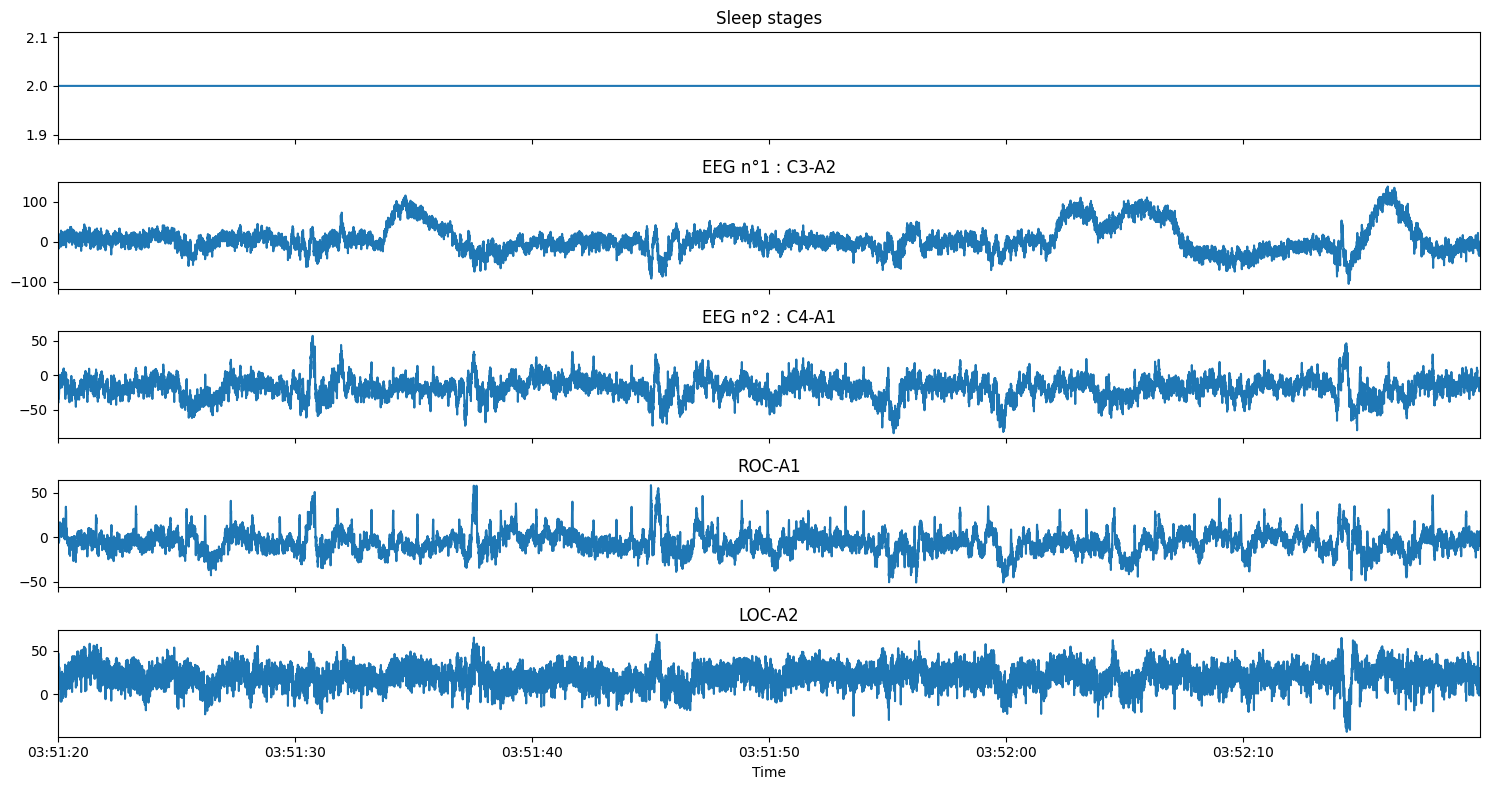

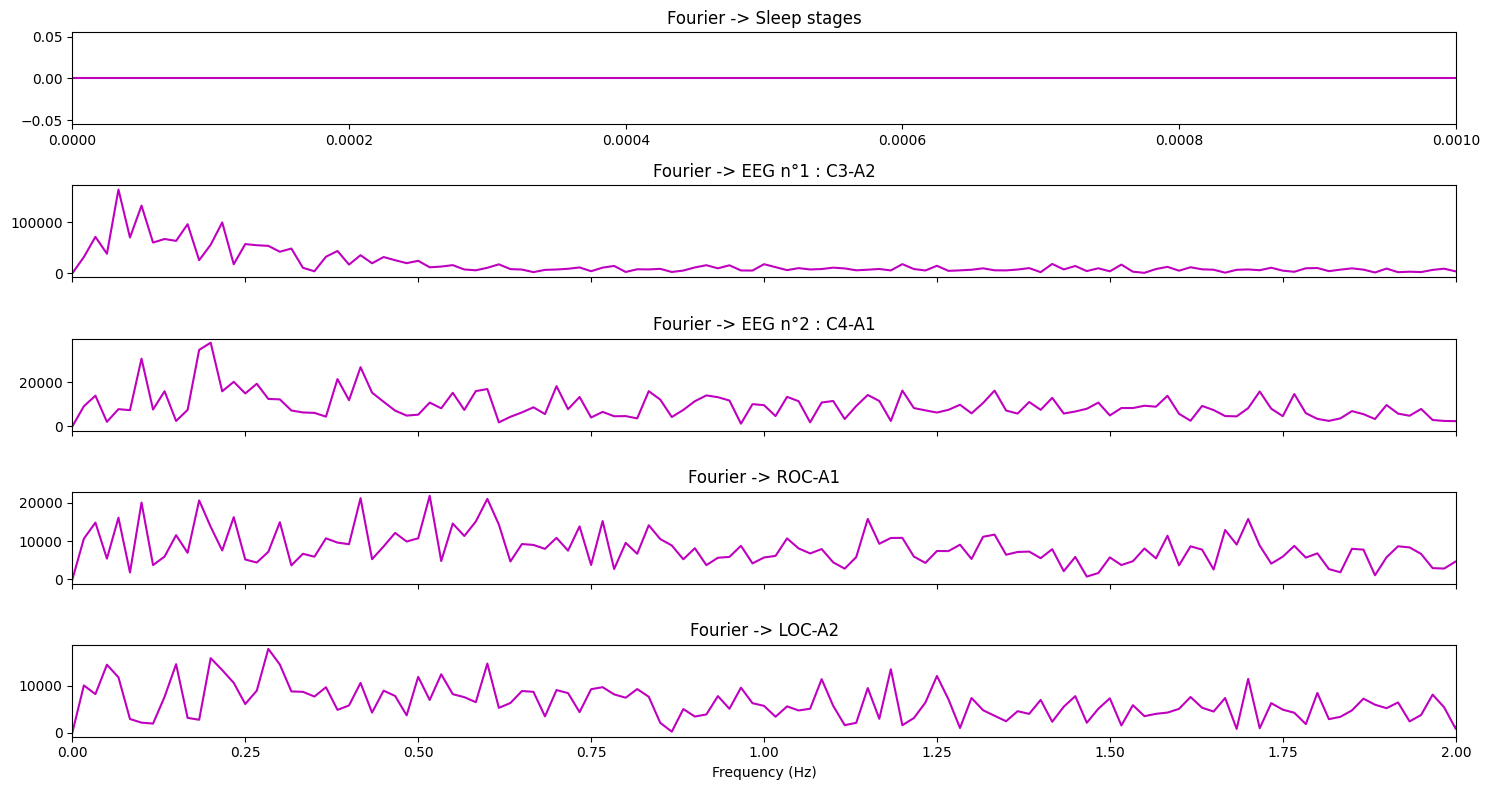

(3553280, 3568640)

In [34]:
exploration(start_time = '03:51:20', duration = 1)

##Sleep stage : stage 1 but *high* amplitude OC

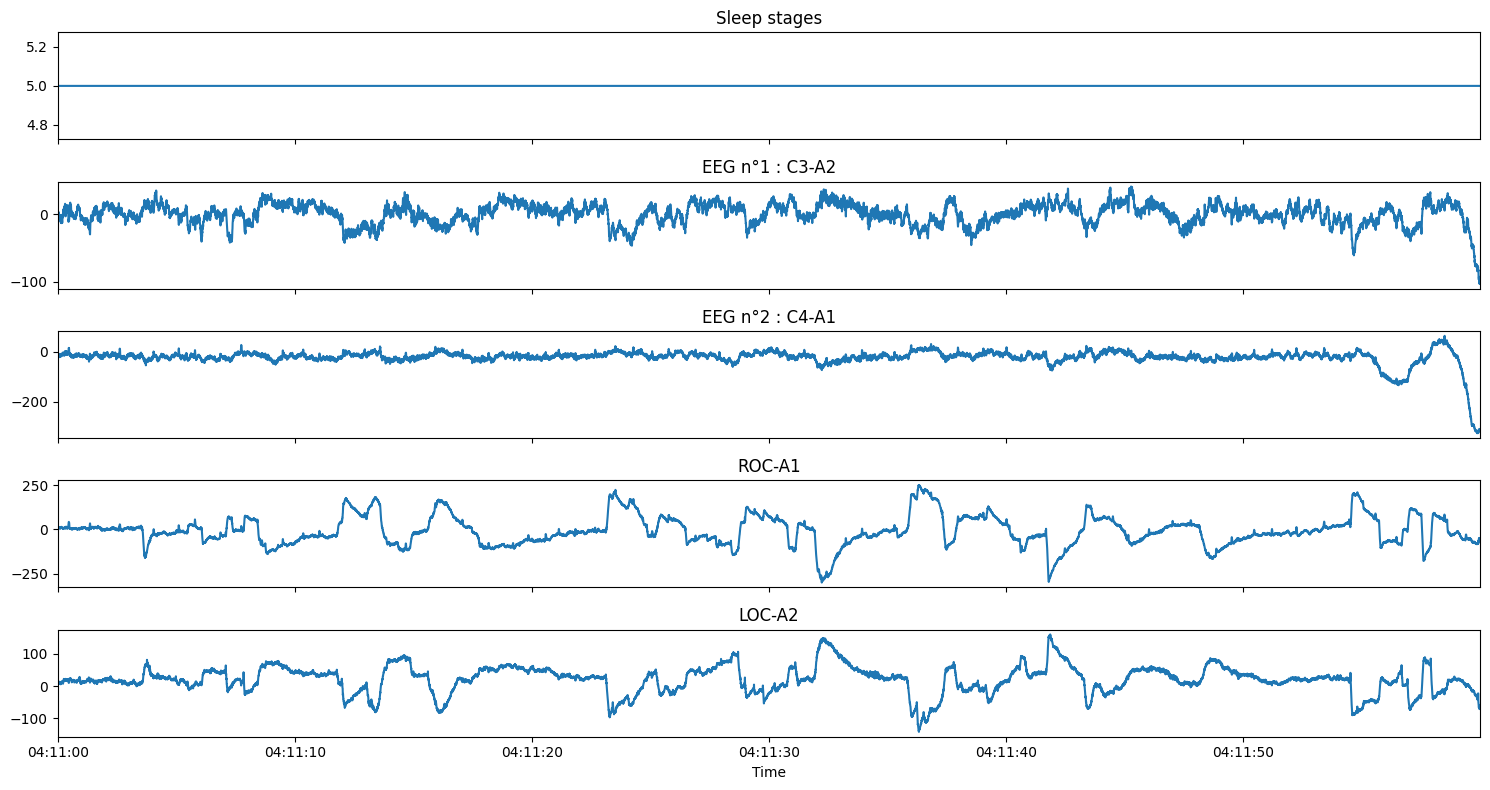

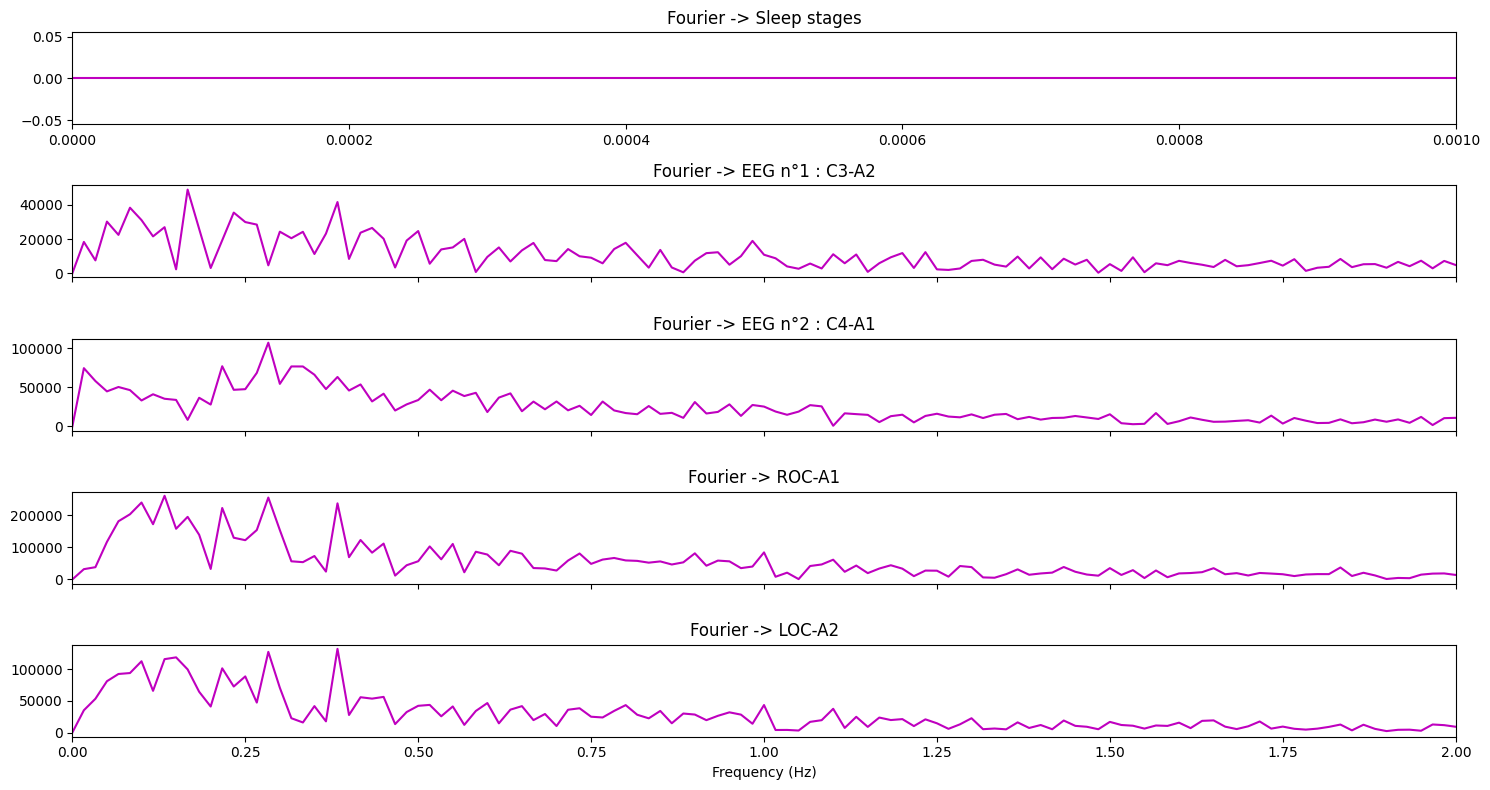

(3855360, 3870720)

In [35]:
exploration(start_time = '04:11:00', duration = 1)

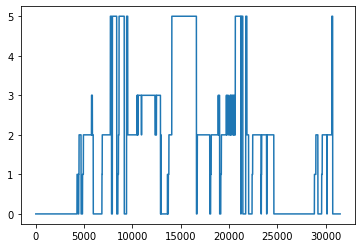

In [36]:
plt.plot(time,sleep_stages)